# Trip Extraction
This code presents how to go from the raw survey data to a clean dataset only including the useful data needed to perform the extended radiation model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Trip Data

In [2]:
viaje = pd.read_csv('../data/eod_2017_csv/tviaje_eod2017/conjunto_de_datos/tviaje.csv')
viaje = viaje[['id_soc', 'dto_origen', 'dto_dest', 'p5_9_1', 'p5_9_2', 'p5_10_1', 'p5_10_2', 'p5_13', 'factor']]
viaje = viaje.rename(columns={'dto_origen':'origin', 'dto_dest':'destination', 'p5_9_1':'departure_h', 'p5_9_2':'departure_min', 'p5_10_1':'arrival_h', 'p5_10_2':'arrival_min', 'p5_13':'purpose'})

In [3]:
# Remove all the trips going out of the zone
# because we cannot assign any centroid to those locations
viaje = viaje[~((viaje['origin'].isin([888,999])) | (viaje['destination'].isin([888,999])))]

# Rename disctrict with numbers from 0 to 193
keys = np.sort(viaje.origin.unique())
values = np.arange(len(viaje.origin.unique()))
dictionary = dict(zip(keys, values))
viaje['origin'] = viaje['origin'].map(dictionary)
viaje['destination'] = viaje['destination'].map(dictionary)

viaje.head()

,id_soc,origin,destination,departure_h,departure_min,arrival_h,arrival_min,purpose,factor
0,1268,1,15,8,0,9,0,2,244
1,1268,15,1,14,0,15,30,1,244
2,1268,1,1,17,0,17,5,5,244
3,1268,1,1,23,0,23,5,1,244
4,1269,1,15,8,0,9,0,2,244


In [4]:
trips_between_districts = viaje.groupby(['origin', 'destination'])['id_soc'].count().rename('count')
trips_between_districts = trips_between_districts.reset_index()
trips_between_districts.head()

,origin,destination,count
0,0,0,1339
1,0,1,156
2,0,2,204
3,0,3,185
4,0,4,161


In [5]:
inter_districts_trips = trips_between_districts[~(trips_between_districts['origin'] == trips_between_districts['destination'])]
intra_districts_trips = trips_between_districts[(trips_between_districts['origin'] == trips_between_districts['destination'])]

In [6]:
print('Total number of trips recorded', len(viaje))
print('of which', inter_districts_trips['count'].sum(), 'are trips between districts (inter districts trips) \nand', intra_districts_trips['count'].sum(),'are local trips (intra district trips)')

Total number of trips recorded 485009
of which 286155 are trips between districts (inter districts trips) 
and 198854 are local trips (intra district trips)


In [7]:
# Create the matrix 'links': origin / destination / number of trips / distance

def FindDistance(row):
    origin = row[0].astype(int)
    destination = row[1].astype(int)
    distance = dist_cell[origin, destination]
    return(distance)

dist_cell = np.loadtxt('../data/dist_cell.txt')

trips_between_districts['distance'] = trips_between_districts.apply(FindDistance, axis=1)
trips_between_districts.head()

,origin,destination,count,distance
0,0,0,1339,0.000000
1,0,1,156,2.431160
2,0,2,204,2.143412
3,0,3,185,2.238830
4,0,4,161,3.892406


In [8]:
links = trips_between_districts.values
np.savetxt('../data/links.txt', links)

### Trip Attraction
The following cell gives the trip attraction of each of the 194 districts of the MZVM

In [9]:
trip_attraction = inter_districts_trips.groupby('destination').sum()['count']
trip_attraction.head()

destination
0    8336
1    4224
2    2018
3    2555
4    1872
Name: count, dtype: int64

In [10]:
# CHECK
assert(trip_attraction.sum() < len(viaje))    # no more than the total number of trips
assert(len(trip_attraction) == 194)           # number of districts

In [11]:
np.savetxt('../data/trip_attraction.txt', trip_attraction, fmt='%.2f')

### Trip Production
The following cell gives the trip production of each of the 194 districts of the MZVM

In [12]:
trip_production = inter_districts_trips.groupby('origin').sum()['count']
trip_production.head()

origin
0    8241
1    4117
2    1979
3    2499
4    1819
Name: count, dtype: int64

In [13]:
# CHECK
assert(trip_production.sum() < len(viaje))    # no more than the total number of trips
assert(len(trip_production) == 194)           # number of districts

In [14]:
np.savetxt('../data/trip_production.txt', trip_production)

### Population

In [15]:
vivienda = pd.read_csv('../data/eod_2017_csv/tvivienda_eod2017/conjunto_de_datos/tvivienda.csv')

In [16]:
vivienda['pop'] = vivienda['p1_1'] * vivienda['factor']
vivienda_pop = vivienda[['distrito', 'pop']]
vivienda_pop = vivienda_pop.append({'distrito': 34, 'pop':0}, ignore_index=True)
vivienda_pop_district = vivienda_pop.groupby(by='distrito').sum().reset_index()
vivienda_pop_district.head()

,distrito,pop
0,1,75988
1,2,128035
2,3,134621
3,4,108158
4,5,124864


In [17]:
population = vivienda_pop_district['pop'].values

In [18]:
# CHECK
assert(population.sum() > 20000000)          # total population in MZVM
assert(len(vivienda_pop_district) == 194)    # number of districts

In [19]:
# save population per district ordered by districts
np.savetxt('../data/pop.txt', population)

### Scaling factor  $\gamma$

In [20]:
gamma = trip_production.sum() / population.sum()
gamma

0.01370034322793789

### POIs

In [21]:
poi = pd.read_csv('../data/district_poi.csv')
poi = poi[['Distrito', 'dto_poi']]
poi['dto_poi'] = poi['dto_poi'].astype(int)
poi = poi['dto_poi']
poi.head()

0    20812
1    15912
2     6108
3     6056
4     6348
Name: dto_poi, dtype: int64

In [22]:
# save POI per district ordered by districts
np.savetxt('../data/poi.txt', poi)

---

# Correlations

In [23]:
from sklearn.linear_model import LinearRegression

R-squared = 0.0213


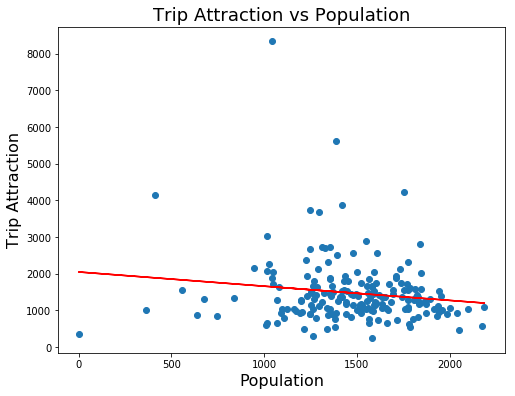

In [24]:
# Trip attraction vs Population

model = LinearRegression()
trip_production_from_population = np.array(population).reshape(-1, 1) * gamma
model.fit(trip_production_from_population, trip_attraction)
r2 = model.score(trip_production_from_population, trip_attraction)

plt.figure(figsize=(8,6))
plt.scatter(trip_production_from_population, trip_attraction)
plt.plot(trip_production_from_population, model.predict(trip_production_from_population), c='r')
plt.xlabel('Population', fontsize=16)
plt.ylabel('Trip Attraction', fontsize=16)
plt.title('Trip Attraction vs Population', fontsize=18)

print("R-squared = {:.4f}".format(r2))

R-squared = 0.0214


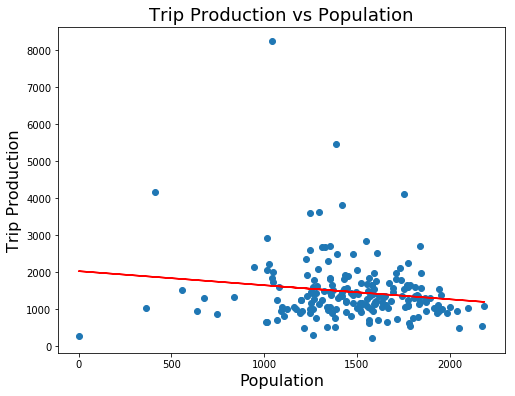

In [25]:
# Trip Production vs Population

trip_attraction_from_population = np.array(population).reshape(-1, 1) * gamma

model = LinearRegression()
model.fit(trip_attraction_from_population, trip_production)
r2 = model.score(trip_attraction_from_population, trip_production)

plt.figure(figsize=(8,6))
plt.scatter(trip_attraction_from_population, trip_production)
plt.plot(trip_attraction_from_population, model.predict(trip_attraction_from_population), c='r')
plt.xlabel('Population', fontsize=16)
plt.ylabel('Trip Production', fontsize=16)
plt.title('Trip Production vs Population', fontsize=18)

print("R-squared = {:.4f}".format(r2))

R-squared = 0.7285


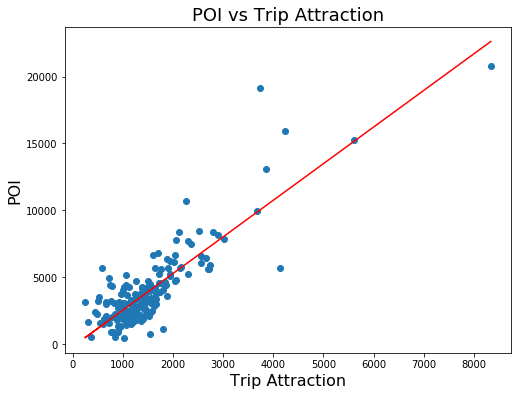

In [26]:
# POI vs Trip Attraction

model = LinearRegression()
model.fit(np.array(trip_attraction).reshape(-1, 1), poi)
r2 = model.score(np.array(trip_attraction).reshape(-1, 1), poi)

plt.figure(figsize=(8,6))
plt.scatter(trip_attraction, poi)
plt.plot(trip_attraction, model.predict(np.array(trip_attraction).reshape(-1, 1)), c='r')
plt.xlabel('Trip Attraction', fontsize=16)
plt.ylabel('POI', fontsize=16)
plt.title('POI vs Trip Attraction', fontsize=18)

print("R-squared = {:.4f}".format(r2))